In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

from core.sepsisSimDiabetes.State import State
from core.sepsisSimDiabetes.Action import Action
from core import generator_confounded_mdp as DGEN
from core import conf_wis as CWIS
from core import loss_minimization as LB
from utils.utils import *

# Quantify s,a-rectangular vs s-rectangular

In [4]:
envs = []
# # each row:
# #   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toy227(0.25, 0.35)
toy = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toy, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 4
graph_len = 4
pi_b, P, R, x_dist, u_dist, gamma = confound_env.graph_opetools(horizon=graph_len, slip=0.25, confound_weight=0.23)
R = -1*R
graph = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([graph, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 20
pi_b, P, R, x_dist, u_dist, gamma = confound_env.toymc_opetools(n_left=8, n_right=8, horizon=20, slip=0.15, confound_weight=0.6)
#R = -1*R
toymc = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.15, 0.85]
    
envs.append([toymc, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 8
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

In [8]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [10, 100, 1000000]
nPbs = len(Pbs)

for mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term in envs:
    
    print("---")
    
    print("running env with horizon " + str(horizon))

    dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon)
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    Phat = confound_ope.estimate_P(dataset, mdp)
    pihat = confound_ope.estimate_pi(dataset, mdp)
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

    # no confounding:
    print("value of pi_e with no confounding")
    Q0 = np.zeros((nStates, nActions))
    nom_q = Q0.copy()
    for t in range(horizon):
        nom_q = confound_ope.fitted_q_update(nom_q, pi_e, dataset, mdp)
    print(mdp.get_value(nom_q,pi_e)[1])

    fqe_results = np.zeros((nGams))

    print("now running C-FQE")
    for i,gam in enumerate(gams):
        Q0 = np.zeros((nStates, nActions))
        q_reparam_samp = Q0.copy()
        for t in range(horizon):
            q_reparam_samp = confound_ope.fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Phat, gam, data, mdp)
        fqe_results[i] = mdp.get_value(q_reparam_samp,pi_e)[1]
    
    print("now running robust mdps...")
    mb_results = np.zeros((nGams, nPbs))

    for i,gam in tqdm(enumerate(gams)):
        for j,P_bound in enumerate(Pbs):
            V0 = np.zeros(nStates)
            fixed_u_v = V0.copy()
            for t in range(horizon):
                fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
            mb_results[i,j] = fixed_u_v @ mdp.x_dist
    
    fqe_envs.append(fqe_results)
    mb_envs.append(mb_results)

---
running env with horizon 5
value of pi_b
0.3668725330933333
value of pi_e with no confounding
0.526394824523333
now running C-FQE
now running robust mdps...


8it [00:07,  1.14it/s]


---
running env with horizon 4
value of pi_b
-0.16962847146666665
value of pi_e with no confounding
0.7055853890422374
now running C-FQE
now running robust mdps...


8it [00:21,  2.65s/it]


---
running env with horizon 20
value of pi_b
-18.199751231562956
value of pi_e with no confounding
-15.419511924549324
now running C-FQE
now running robust mdps...


8it [05:49, 43.64s/it]


---
running env with horizon 8
value of pi_b
-0.5161960485905009
value of pi_e with no confounding
-0.36401639116255213
now running C-FQE
now running robust mdps...


8it [04:10, 31.30s/it]


In [9]:
pi_e_vals = [0.5216884170673105, 0.7048948127277515, -15.55707804040286, -0.36469420911599565]
pi_b_vals = [0.3583150819466666 , -0.19389135706666666, -18.195800126342863, -0.5081900982251686]

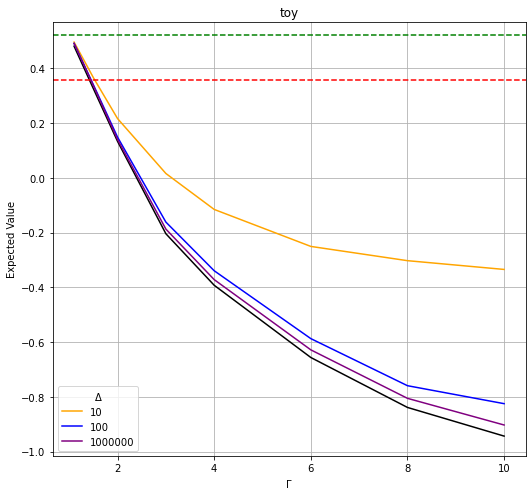

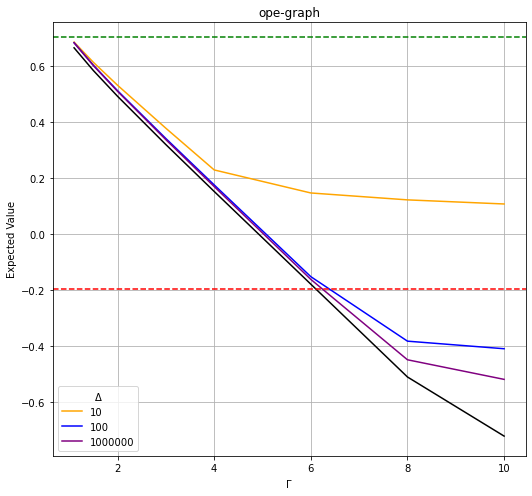

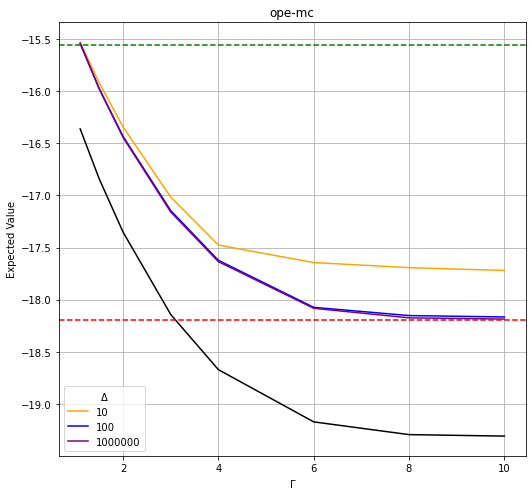

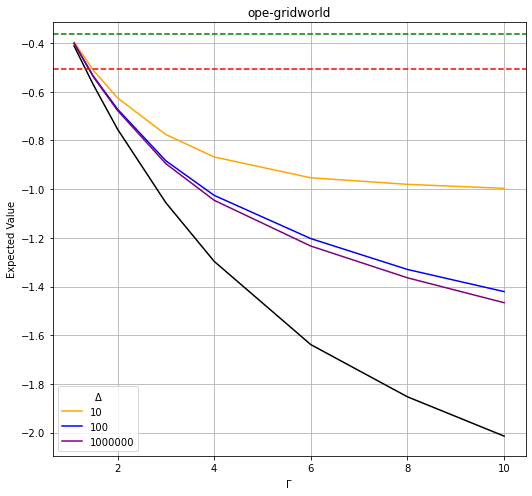

In [10]:
from matplotlib import colors

import matplotlib

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [10, 100, 1000000]
nPbs = len(Pbs)

deltacol = ["orange", "blue", "purple"]

count = 0
envTitles = ["toy", "ope-graph", 'ope-mc', 'ope-gridworld']

for fqe_results, mb_results in zip(fqe_envs,mb_envs):
    fig = plt.figure()
    fig.set_size_inches(7.5, 7)
    plt.plot(gams,fqe_results, color='k')
    for p in range(nPbs):
        plt.plot(gams, mb_results[:,p], color=deltacol[p], label="{0}".format(Pbs[p]))
    plt.axhline(pi_e_vals[count], color='green', linestyle='--')
    plt.axhline(pi_b_vals[count], color='red', linestyle='--')
    plt.ylabel("Expected Value")
    plt.xlabel("$\Gamma$")
    plt.title(envTitles[count])
    plt.grid()
    plt.legend(title="$\Delta$")
    plt.tight_layout()
    fig.savefig("sa_rect_plot_%s.pdf" % count)
    count += 1